In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
from jax import random
from scipy.linalg import expm
from typing import Callable

key = random.PRNGKey(0)


2024-11-28 16:59:58.025024: W external/xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.3 which is older than the PTX compiler version 12.6.77. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
# define the input

key, subkey = random.split(key)
# X = jnp.array([[0.2, 0.4, 0.8],[1,1,1]])

# X = jnp.array([[0.2, 1],[0.4, 1],[0.8, 1]])
X = jnp.array([[0.2],[0.4],[0.8]])
X_test = jnp.array([0.3, 0.5, 0.7])
y = jnp.array([[-0.05],[-0.2],[0.3]])

D_in = X.shape[1]
D_out = y.shape[1]
N = X.shape[0]
n_hidden = 1
D_hidden = 3

In [3]:
D_in, D_out, N

(1, 1, 3)

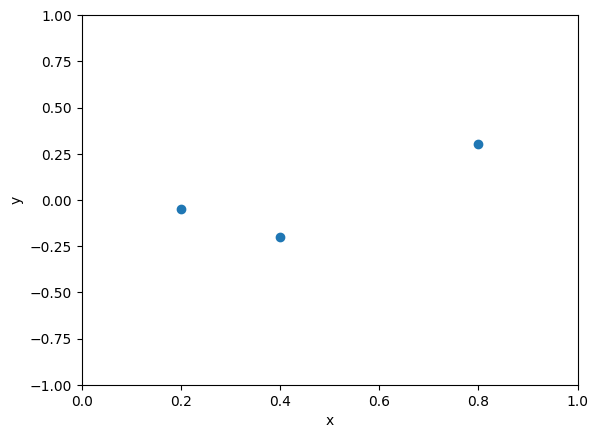

In [4]:
fig, ax = plt.subplots()
ax.plot(X[:], y, 'o')
ax.set_xlim(0,1)
ax.set_ylim(-1,1)
ax.set_xlabel('x')
ax.set_ylabel('y');
plt.show()


In [5]:

def deriv_of_activation(foo: Callable) -> Callable:
    """
    Returns the derivative of the activation function `foo`.
    """
    return jax.grad(foo)



def use_derivative_of_activation(foo: Callable) -> Callable:
    """
    Returns the derivative of the activation function `foo`.
    """
    return jax.vmap(jax.grad(foo))

In [6]:
def shallow_network(X, params, activation):
    """
    A simple shallow neural network with one hidden layer.
    """    
    # linear transformation
    
    for w, b in params:

        # linear transformation
        if len(X.shape) == 1:
            X = w*X + b
        else:
            X = w@X + b

        
        
        h_x_1 = activation(X[0])/jnp.sqrt(X.shape[0])
    return X


def init_params(key, D_in, D_out, n_hidden, D_hidden):
    """
    Initialize the parameters of the shallow network.
    """
    params = []
    key, subkey = random.split(key)
    omega0 = random.normal(key, (D_hidden, D_in))
    key, subkey = random.split(key)
    bias0 = random.normal(key, (D_hidden, 1))
    params += [(omega0, bias0)]
    
    for i in range(n_hidden):
        key, subkey = random.split(key)
        omega = random.normal(key, (D_hidden, D_hidden))
        key, subkey = random.split(key)
        bias = random.normal(key, (D_hidden, 1))
        params += [(omega, bias)]
        
    key, subkey = random.split(key)
    output_omega = random.normal(key, (D_out, D_hidden))
    output_bias = random.normal(key, (D_out, 1))
    params += [(output_omega, output_bias)]
    return params
        

    
params = init_params(
    key=key, D_in=D_in, D_out=D_out, n_hidden=n_hidden, D_hidden=D_hidden
)
    
    


y_pred = jax.vmap(shallow_network, in_axes=(0, None,None))(X, params, jnp.sin)
y_pred
# shallow_network(jnp.array([0]), params, jnp.sin)

Array([[[-1.5149397]],

       [[-1.8384994]],

       [[-2.4856193]]], dtype=float32)

In [7]:



def alt_compute_empirical_ntk(X_1, X_2, params, activation):
    
    
    N_1 = X_1.shape[1]
    N_2 = X_2.shape[1]
    K = np.zeros((N_1, N_2))
    
    
    if isinstance(X_1.shape,int):
        preactivation_1 = params[0][0]*X_1 + params[0][1]
        preactivation_2 = params[0][0]*X_2 + params[0][1]
    else:
        preactivation_1 = params[0][0]@X_1 + params[0][1]
        preactivation_2 = params[0][0]@X_2 + params[0][1]
    
    for i in range(N_1):
        for j in range(N_2):
            K[i, j] = jnp.mean(activation(preactivation_1[:, i])*activation(preactivation_2[:, j]))+1
            K[i, j] += X_1[:, i]@X_2[:, j].T*jnp.mean(
                jnp.square(params[1][0])
                *use_derivative_of_activation(activation)(preactivation_1[:, i])
                *use_derivative_of_activation(activation)(preactivation_2[:, j])
            )
    return K

In [8]:

def k_null(X_1, X_2):
    return X_1.T@X_2 +1

def k_prime_null(X_1, X_2):
    return X_1.T@X_2

def next_layer_K(X_1, X_2, l,  params, f: Callable):
    
    h_x_1 =X_1
    h_x_2 = X_2
    for w, b in params[:l]:
        # linear transformation
        if len(h_x_1.shape) == 1:
            h_x_1 = w*h_x_1 + b
            h_x_2 = w*h_x_2 + b
        else:
            h_x_1 = w@h_x_1 + b
            h_x_2 = w@h_x_2 + b

        h_x_1 = f(h_x_1)/jnp.sqrt(h_x_1.shape[0])
        h_x_2 = f(h_x_2)/jnp.sqrt(h_x_2.shape[0])
 
    return jnp.mean(h_x_1.T@h_x_2)


def next_layer_K_prime(X_1, X_2, l,  params, f: Callable):
    
    f_prime = jax.vmap(jax.grad(f))
    
    
    h_x_1 =X_1
    h_x_2 = X_2

    for w, b in params[:l]:
        # linear transformation
        if len(h_x_1.shape) == 1:
            h_x_1 = w*h_x_1 + b
            h_x_2 = w*h_x_2 + b
        else:
            h_x_1 = w@h_x_1 + b
            h_x_2 = w@h_x_2 + b

        
        
        h_x_1 = f_prime(h_x_1[0])/jnp.sqrt(h_x_1.shape[0])
        h_x_2 = f_prime(h_x_2[0])/jnp.sqrt(h_x_2.shape[0])
 
    return jnp.mean(h_x_1.T@h_x_2)
    
    
def analytical_NTK(X_1, X_2, params, activation):
    """
    Compute the analytical NTK for the shallow network.
    """
    K = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            for h in range(len(params)):
                if h == 0:
                    K[i, j] = jnp.mean(activation(X_1[:, i])*activation(X_2[:, j]))+1
                else:
                    k_h = next_layer_K(X_1[i], X_2[j], h, params, activation)
                    k_h_prime = next_layer_K_prime(X_1[i], X_2[j], h, params, activation)
                    mult = jnp.multiply(k_h_prime, K[i, j])
                    K[i, j] = k_h + mult + 1
    return K
                    
    


In [9]:
analytical_NTK(X, X, params, jnp.sin)

array([[2.55400085, 2.48130178, 2.26969242],
       [2.48130178, 2.50177932, 2.44701076],
       [2.26969242, 2.44701076, 2.68728256]])

In [12]:



# im not sure if i should be differentiating the network wrt the parameters or the inputs
def derivative_of_networks_wrt_params(X, params, activation):
    """
    Compute the derivative of the network with respect to the parameters.
    """
    return jax.vmap(lambda x: jax.jacobian(shallow_network, argnums=0)(x, params, activation))(X).T


derivative_of_networks_wrt_params(X, params, jnp.sin)

Array([[[[-1.6178, -1.6178, -1.6178]]]], dtype=float32)

In [13]:


# def moore_penrose_inverse(A)
def phi_t(X, y, act, t):
    """
    estimate of params at time t
    """
    params = init_params(key=random.PRNGKey(0), D_in=D_in, D_out=D_out, n_hidden=n_hidden, D_hidden=D_hidden)
    
    first_pred = jax.vmap(shallow_network, in_axes=(0, None, None))(X, params, act)
    phi_ts = []
    ntk = analytical_NTK(X, X, params, act)
    df_dphi = derivative_of_networks_wrt_params(X, params, act)
    
    for i in range(t):
        v = jnp.linalg.inv(ntk)*(jnp.identity(N) - expm(-t*ntk) )*(first_pred - y)
        phi_t = df_dphi@v
        phi_ts.append(phi_t)
    return phi_ts



phi_t(X, y, jnp.sin, 1)

    
    

[Array([[[[ 622.6655 , -966.14746,  347.57178]],
 
         [[ 622.7124 , -966.1006 ,  347.61902]],
 
         [[ 622.8069 , -966.00586,  347.71338]]]], dtype=float32)]